We test out theory predictions agains the Websky sims https://mocks.cita.utoronto.ca/index.php/WebSky_Extragalactic_CMB_Mocks

Note: I have not yet translated the curved-sky functionality of quicklens to Python3. So we need to run this notebook in a Python2 environment running the Python2 version of quicklens

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import quicklens as ql
import healpy as hp
import csbt

IMPORT ERROR: /Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/quicklens/mpi.pyc (No module named pypar). Could not load pbs or pypar. MPI will not be used.


Write a function to bin the per-multipole spectra we'll be taking with anafast

In [2]:
def uniformly_bin_spectrum(data, bin_width, return_ells=False):
    '''
    data = 1D numpy array of size lmax containing spectrum to be binned. Assumed that first entry is for l=0
    bin_width = bin width for uniform binning
    '''
    binned_data = data[:(data.size // bin_width) * bin_width].reshape(-1, bin_width).mean(axis=1)
    ells = np.arange(len(data))
    binned_ells_centers = ells[:(ells.size // bin_width) * bin_width].reshape(-1, bin_width).mean(axis=1)
    if return_ells:
        return binned_data, binned_ells_centers
    else:
        return binned_data

# Option 1: Run from script

Run the script /Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky.py

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in divide
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


<Figure size 360x360 with 0 Axes>

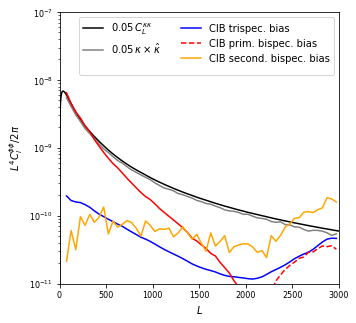

In [4]:
plt.figure(figsize=(5,5))

lmax = 3000
run_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside1024_nlevt18.0_beamarcmin1.0/'.format(lmax)

which_bias = 'CIB' # 'tSZ' or 'CIB' or 'all'
bin_width = 50

ells = np.arange(3000 + 1)
#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=3000)
cl_len     = ql.spec.get_camb_lensedcl(lmax=3000)

cmbrec_x_cmbrec = np.load(run_dir + 'cmbrec_x_cmbrec.npy')
true_x_cmbrec = np.load(run_dir + 'true_x_cmbrec.npy')
true_x_true = np.load(run_dir + 'true_x_true.npy')
fgonlyrec_x_fgonlyrec = np.load(run_dir + '{}onlyrec_x_{}onlyrec.npy'.format(which_bias, which_bias))
cmbonly_x_fgonlyrec = np.load(run_dir + 'cmbonly_x_{}onlyrec.npy'.format(which_bias))
mixedrec_x_mixedrec = np.load(run_dir + 'mixed_cmb{}_rec_x_mixed_cmb{}_rec.npy'.format(which_bias, which_bias))
nlpp_TT_fullsky = np.load(run_dir + 'N0_TT_fullsky_{}.npy'.format(which_bias))

kappa_to_phi_conversion = np.nan_to_num(1 / (0.5 * ells * (ells + 1)))
scaling = ells ** 4 / (2 * np.pi) * kappa_to_phi_conversion ** 2

# Get the binned ells
ells = uniformly_bin_spectrum(cmbrec_x_cmbrec, bin_width, return_ells=True)[1]
# PLOT
plt.figure(figsize=(5, 5))

plt.semilogy(cl_unl.ls, 0.05 * cl_unl.ls ** 4 * cl_unl.clpp / (2 * np.pi), 'k', label=r'$0.05\,C_L^{\kappa \kappa}$')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * cmbrec_x_cmbrec, bin_width), label='0.05*cmbrec_x_cmbrec', color='brown')
plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_cmbrec, bin_width), label=r'$0.05\, \kappa \times \hat{\kappa}$', color='gray')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_true, bin_width), label='0.05*true_x_true', color='green')

plt.semilogy(ells, ells, color='w', label=' ')
plt.semilogy(ells, uniformly_bin_spectrum(scaling * (fgonlyrec_x_fgonlyrec - nlpp_TT_fullsky), bin_width), label='{} trispec. bias'.format(which_bias), color='b')
plt.semilogy(ells, uniformly_bin_spectrum(- 2 * scaling * cmbonly_x_fgonlyrec, bin_width), label='{} prim. bispec. bias'.format(which_bias), color='r', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(2 * scaling * cmbonly_x_fgonlyrec, bin_width), color='r')

plt.semilogy(ells, uniformly_bin_spectrum(-4 * scaling * mixedrec_x_mixedrec, bin_width), color='orange', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(4 * scaling * mixedrec_x_mixedrec, bin_width), label='{} second. bispec. bias'.format(which_bias),
                 color='orange')
# plt.semilogy((1.0 / 4) * 1. / norm * cl_unl.ls ** 4, label='N^0')

#plt.title(r'TT reconstruction on WebSky, l$_{\mathrm{max}}=$'+str(lmax))
#plt.annotate(r'$0.05\,C_L^{\kappa \kappa}$', (2500,4e-11), rotation=-8)
plt.xlabel(r'$L$')
plt.ylabel(r'$L^4 C_l^{\phi\phi}/ 2 \pi$')
plt.xlim([2, 3000])
plt.ylim([1e-11, 1e-7])
plt.legend(ncol=2, columnspacing=2)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

thesis_dir = '/Users/antonbaleatolizancos/Desktop/THESIS/phd_thesis/Chapter4/plots_lensing_rec_biases/'
plt.savefig(thesis_dir+'{}_biases_on_websky_lmax{}.pdf'.format(which_bias, lmax), bbox_inches='tight')

For the mixed cib-tsz biases, run the cell below

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in square
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply


<Figure size 360x360 with 0 Axes>

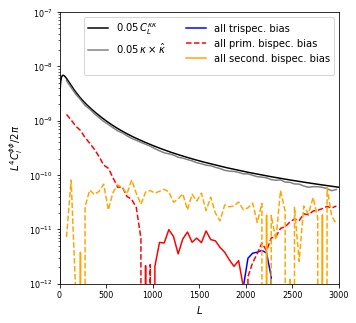

In [16]:
plt.figure(figsize=(5,5))

lmax = 3000
run_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside1024_nlevt18.0_beamarcmin1.0/'.format(lmax)

which_bias = 'all' # 'tSZ' or 'CIB' or 'all'
bin_width = 50

ells = np.arange(3000 + 1)
#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=3000)
cl_len     = ql.spec.get_camb_lensedcl(lmax=3000)

cmbrec_x_cmbrec = np.load(run_dir + 'cmbrec_x_cmbrec.npy')
true_x_cmbrec = np.load(run_dir + 'true_x_cmbrec.npy')
true_x_true = np.load(run_dir + 'true_x_true.npy')
fgonlyrec_x_fgonlyrec = np.load(run_dir + '{}onlyrec_x_{}onlyrec.npy'.format(which_bias, which_bias))
cmbonly_x_fgonlyrec = np.load(run_dir + 'cmbonly_x_{}onlyrec.npy'.format(which_bias))
mixedrec_x_mixedrec = np.load(run_dir + 'mixed_cmb{}_rec_x_mixed_cmb{}_rec.npy'.format(which_bias, which_bias))
nlpp_TT_fullsky = np.load(run_dir + 'N0_TT_fullsky_{}.npy'.format(which_bias))

# Subtract the CIB biases
fgonlyrec_x_fgonlyrec -= np.load(run_dir + '{}onlyrec_x_{}onlyrec.npy'.format('CIB', 'CIB'))
cmbonly_x_fgonlyrec -= np.load(run_dir + 'cmbonly_x_{}onlyrec.npy'.format('CIB'))
mixedrec_x_mixedrec -= np.load(run_dir + 'mixed_cmb{}_rec_x_mixed_cmb{}_rec.npy'.format('CIB', 'CIB'))

# Subtract the tSZ biases
fgonlyrec_x_fgonlyrec -= np.load(run_dir + '{}onlyrec_x_{}onlyrec.npy'.format('tSZ', 'tSZ'))
cmbonly_x_fgonlyrec -= np.load(run_dir + 'cmbonly_x_{}onlyrec.npy'.format('tSZ'))
mixedrec_x_mixedrec -= np.load(run_dir + 'mixed_cmb{}_rec_x_mixed_cmb{}_rec.npy'.format('tSZ', 'tSZ'))


kappa_to_phi_conversion = np.nan_to_num(1 / (0.5 * ells * (ells + 1)))
scaling = ells ** 4 / (2 * np.pi) * kappa_to_phi_conversion ** 2

# Get the binned ells
ells = uniformly_bin_spectrum(cmbrec_x_cmbrec, bin_width, return_ells=True)[1]
# PLOT
plt.figure(figsize=(5, 5))

plt.semilogy(cl_unl.ls, 0.05 * cl_unl.ls ** 4 * cl_unl.clpp / (2 * np.pi), 'k', label=r'$0.05\,C_L^{\kappa \kappa}$')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * cmbrec_x_cmbrec, bin_width), label='0.05*cmbrec_x_cmbrec', color='brown')
plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_cmbrec, bin_width), label=r'$0.05\, \kappa \times \hat{\kappa}$', color='gray')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_true, bin_width), label='0.05*true_x_true', color='green')

plt.semilogy(ells, ells, color='w', label=' ')
plt.semilogy(ells, uniformly_bin_spectrum(scaling * (fgonlyrec_x_fgonlyrec - nlpp_TT_fullsky), bin_width), label='{} trispec. bias'.format(which_bias), color='b')
plt.semilogy(ells, uniformly_bin_spectrum(- 2 * scaling * cmbonly_x_fgonlyrec, bin_width), label='{} prim. bispec. bias'.format(which_bias), color='r', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(2 * scaling * cmbonly_x_fgonlyrec, bin_width), color='r')

plt.semilogy(ells, uniformly_bin_spectrum(-4 * scaling * mixedrec_x_mixedrec, bin_width), color='orange', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(4 * scaling * mixedrec_x_mixedrec, bin_width), label='{} second. bispec. bias'.format(which_bias),
                 color='orange')
# plt.semilogy((1.0 / 4) * 1. / norm * cl_unl.ls ** 4, label='N^0')

#plt.title(r'TT reconstruction on WebSky, l$_{\mathrm{max}}=$'+str(lmax))
#plt.annotate(r'$0.05\,C_L^{\kappa \kappa}$', (2500,4e-11), rotation=-8)
plt.xlabel(r'$L$')
plt.ylabel(r'$L^4 C_l^{\phi\phi}/ 2 \pi$')
plt.xlim([2, 3000])
plt.ylim([1e-12, 1e-7])
plt.legend(ncol=2, columnspacing=2)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

thesis_dir = '/Users/antonbaleatolizancos/Desktop/THESIS/phd_thesis/Chapter4/plots_lensing_rec_biases/'
plt.savefig(thesis_dir+'{}_biases_on_websky_lmax{}.pdf'.format(which_bias, lmax), bbox_inches='tight')

Relative bias plots like in Sailer et al.

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


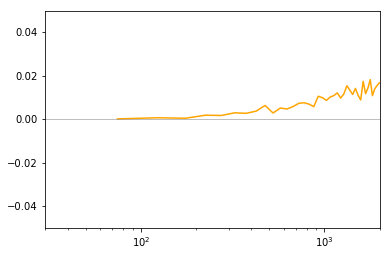

In [8]:
plt.semilogx(ells, uniformly_bin_spectrum((4 * scaling *  mixedrec_x_mixedrec)/(cl_unl.ls**4 * cl_unl.clpp /(2*np.pi)), bin_width), label='mixedrec_x_mixedrec', color='orange')
plt.ylim([-0.05,0.05])
plt.xlim([30,2000])
plt.axhline(0, color='gray', lw=0.5)

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


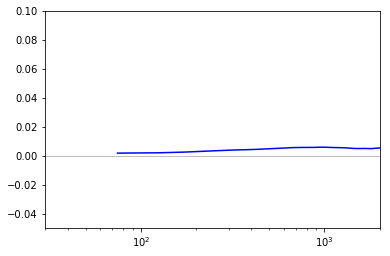

In [11]:
plt.semilogx(ells,  uniformly_bin_spectrum((scaling * (fgonlyrec_x_fgonlyrec-nlpp_TT_fullsky))/(cl_unl.ls**4 * cl_unl.clpp /(2*np.pi)), bin_width), label='fgonlyrec_x_fgonlyrec', color='b')
plt.ylim([-0.05,0.1])
plt.xlim([30,2000])
plt.axhline(0, color='gray', lw=0.5)

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.


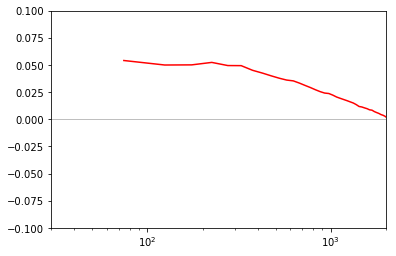

In [10]:
plt.semilogx(ells, uniformly_bin_spectrum(( 2 * scaling * cmbonly_x_fgonlyrec)/(cl_unl.ls**4 * cl_unl.clpp /(2*np.pi)), bin_width), label='cmbonly_x_fgonlyrec', color='r')
plt.ylim([-0.1,0.1])
plt.xlim([30,2000])
plt.axhline(0, color='gray', lw=0.5)

# Option 2: Run on this notebook

## Load the sims

In [98]:
lmax = 100#3000
nside = 64 #1024

Websky foregrounds

In [51]:
websky_dir = '/Volumes/TOSHIBA_EXT/data/sims/websky/'

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
monopole: 0.0084981


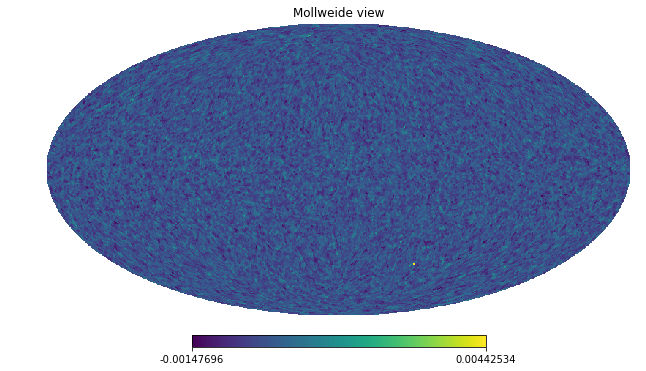

In [119]:
websky_cib = hp.pixelfunc.remove_monopole(hp.ud_grade(hp.read_map(websky_dir+'cib_nu0143.fits'), nside_out=nside))
websky_cib_alm = hp.map2alm(websky_cib, lmax=lmax)
hp.mollview(websky_cib)

When converting the CIB from MJy^2/sr units to CMB temperature. We do this in the notebook /Users/antonbaleatolizancos/Projects/cib_delensing_bias/Getting_unit_conversions_for_ILC_using_astropy.ipynb, for infinitenily narrow bands. These agree with the conversions provided in the websky paper`

In [ ]:
MJy_per_sr_to_uK_at143GHz = 1e6 / (379.93197 )
MJy_per_sr_to_uK_at145GHz = 1e6 / (385.39618 )

First subtract the monopole. Then mask pixels brighter than some value. For now, we use a binary mask (better than using the healpy masking functionality bc quicklens doesn't understand it)

In [146]:
lmax_cib_test = 3000
nside_cib_test = 1024
# Mask pixels above some brightness
masking_threshold_mJy = 5

ells_cib_test = np.arange(lmax_cib_test+1)
cib_map_MJy = hp.pixelfunc.remove_monopole(hp.ud_grade(hp.read_map(websky_dir+'cib_nu0145.fits'), nside_out=nside_cib_test))
unmasked_cib_map_uK = 1e6/385. * cib_map_MJy

# Mask point sources above masking_threshold_mJy
cib_map_mJy = 1e9 * cib_map_MJy 
# Flag the entries to be masked
cib_map_mJy[cib_map_mJy>masking_threshold_mJy] = 0#hp.UNSEEN
# Mask using healpy functionality
masked_cib_map_mJy = cib_map_mJy#hp.pixelfunc.ma(cib_map_mJy)
# Convert from mJy/sr to uK
masked_cib_map_uK =  1e-3/385. * masked_cib_map_mJy

# Take power spectra
unmasked_cib_ps_uKsq = hp.anafast(unmasked_cib_map_uK, lmax=lmax_cib_test)
masked_cib_ps_uKsq = hp.anafast(masked_cib_map_uK, lmax=lmax_cib_test)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
monopole: 0.00888313


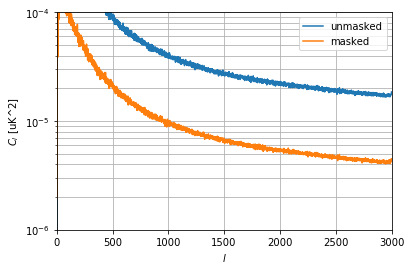

In [147]:
plt.semilogy(ells_cib_test, unmasked_cib_ps_uKsq, label='unmasked' )
plt.semilogy(ells_cib_test, masked_cib_ps_uKsq, label='masked' )

plt.xlim([0, 3000])
plt.ylim([1e-6, 1e-4])
plt.ylabel(r'$C_l$ [uK^2]')
plt.xlabel(r'$l$')
plt.legend()
plt.grid(which='both')

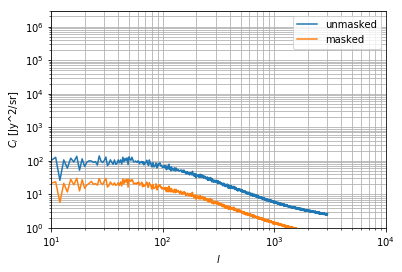

In [148]:
from_uK_to_Jypersr = 385.
plt.loglog(ells_cib_test, from_uK_to_Jypersr**2 *unmasked_cib_ps_uKsq, label='unmasked' )
plt.loglog(ells_cib_test, from_uK_to_Jypersr**2 *masked_cib_ps_uKsq, label='masked' )

plt.xlim([10, 10000])
plt.ylim([1e0, 3e6])
plt.ylabel(r'$C_l$ [Jy^2/sr]')
plt.xlabel(r'$l$')
plt.legend()
plt.grid(which='both')

WebSky tSZ

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


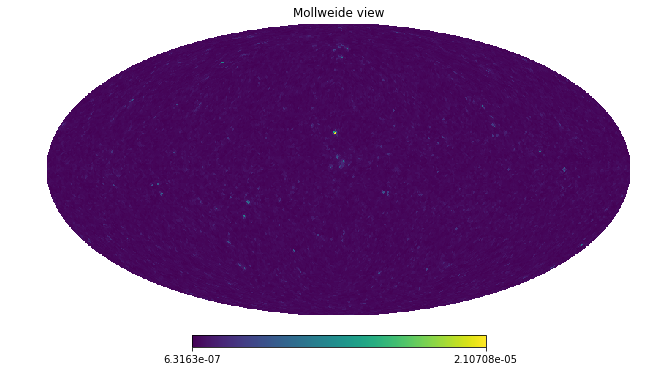

In [12]:
websky_tsz = hp.ud_grade(hp.read_map(websky_dir+'tsz.fits'), nside_out=nside)

websky_tsz_alm = hp.map2alm(websky_tsz, lmax=lmax)
hp.mollview(websky_tsz)

Test the tSZ power spectrum

In [21]:
lmax_tsz_test = lmax #1000
ells_tsz_test = np.arange(lmax_tsz_test+1)
measured_tsz_ps = hp.anafast(hp.ud_grade(hp.read_map(websky_dir+'tsz.fits'), nside_out=256), lmax=lmax_tsz_test)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [22]:
freq_GHz = 150.
T_CMB = 2.73
tsz_scaling = scale_sz(freq_GHz)**2 * T_CMB**2
plt.loglog(ells_tsz_test, 10**12 * ells_tsz_test*(ells_tsz_test+1) / (2 * np.pi) * tsz_scaling * measured_tsz_ps)

plt.xlim([10, 10000])
#plt.ylim([0.5, 10])
plt.ylabel(r'$l(l+1)C_l/2\pi$')
plt.xlabel(r'$l$')
plt.legend()
plt.grid(which='both')

NameError: name 'scale_sz' is not defined

If we compare this to Fig.5 of https://arxiv.org/pdf/2001.08787.pdf, and run some numbers based on the PST and ACT measurements they quote (for example, the SPT measurement is $l(l+1)/2\pi C_l^{TT} = 4\mu K^2$, where $g(\nu)^2 T_{CMB}^2 C^{yy} = C^{TT}$ ), we learn that the maps are in Kelvin.

What's the contribution to N^0 from the tSZ trispectrum? We calculate it analytically using the spectra measured from the sims

In [ ]:
# calculate the noise spectra.
def calc_nlqq(qest, clXX, clXY, clYY, flX, flY):
    clqq_fullsky = qest.fill_clqq(np.zeros(lmax+1, dtype=np.complex), clXX*flX*flX, clXY*flX*flY, clYY*flY*flY)
    resp_fullsky = qest.fill_resp(qest, np.zeros(lmax+1, dtype=np.complex), flX, flY)
    nlqq_fullsky = clqq_fullsky / resp_fullsky**2
    return nlqq_fullsky

def get_fg_N0(measured_fg_ps, nltt):
    """ Get the contribution to N^0 from the fg 4-pt function.
        - Input:
            * measured_fg_ps = np array. Foreground power spectrum measured from the sims.
            * nltt = np array. Intrument noise power spectrum.
    """
    # signal spectra
    sltt       = cl_len.cltt
    # signal+noise spectra
    cltt       = sltt + nltt
    # filter functions
    flt        = np.zeros( lmax+1 ); flt[2:] = 1./cltt[2:]
    # intialize quadratic estimators
    qest_TT    = ql.qest.lens.phi_TT(sltt)
    
    nlpp_TT_fullsky = calc_nlqq( qest_TT, measured_fg_ps, measured_fg_ps, measured_fg_ps, flt, flt )
    return nlpp_TT_fullsky

In [ ]:
beam_size = 1. #arcmin
nlev_t     = 18.0 #temperature noise level, in uK.arcmin.
key = 'ptt' 

#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=lmax)
cl_len     = ql.spec.get_camb_lensedcl(lmax=lmax)

bl = ql.spec.bl(beam_size, lmax) # beam transfer function.

nlev_p     = np.sqrt(2)*nlev_t # polarization noise level, in uK.arcmin.
nltt       = (np.pi/180./60.*nlev_t)**2 / bl**2
nlee=nlbb  = (np.pi/180./60.*nlev_p)**2 / bl**2

beam = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : bl, 'clee' : bl, 'clbb' : bl} ) )
cl_theory  = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : cl_len.cltt, 'clee' : cl_len.clee, 'clbb' : cl_len.clbb} ) )

ivf_lib = ql.sims.ivf.library_diag_full_sky(cl_theory, beam, nlev_t=nlev_t, nlev_p=nlev_p)


In [39]:
nlpp_TT_fullsky = get_fg_N0(measured_tsz_ps, nltt)

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


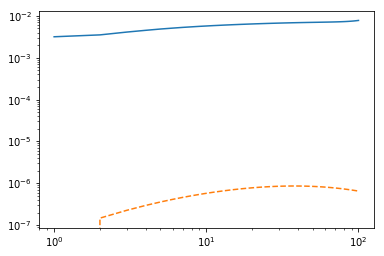

In [40]:
ells = np.arange(lmax+1)
scaling = ells**4 #(ells*(ells+1.))**2/(2.*np.pi)
plt.semilogy(ells, scaling *nlpp_TT_fullsky)
plt.loglog(scaling*cl_unl.clpp, ls='--')

WebSky CMB and kappa

In [8]:
def shorten_alm(input_alm, lmax_new):
    lmax_old = hp.Alm.getlmax(len(input_alm))
    new_size = hp.Alm.getsize(lmax_new)
    output_alm = np.zeros(new_size, dtype=np.complex)
    
    index_in_new = np.arange(len(output_alm))
    l, m = hp.Alm.getlm(lmax_new, i=index_in_new)
    output_alm[index_in_new] = input_alm[hp.Alm.getidx(lmax_old, l, m)]
    return output_alm

websky_unlensed_cmb_alm = shorten_alm(hp.read_alm(websky_dir+'unlensed_alm.fits'), lmax)
websky_cmb_alm = shorten_alm(hp.read_alm(websky_dir+'lensed_alm.fits'), lmax)
Ealm = Balm = np.zeros(websky_cmb_alm.shape)

# Load also the true kappa map
true_kappa = hp.read_map(websky_dir+'kap.fits')

SO CMB

In [3]:
'''
SO_sims_dir = '/Volumes/TOSHIBA_EXT/data/sims/SO/lensed_cmb/'

T_map = hp.ud_grade(hp.read_map(SO_sims_dir+'simonsobs_cmb_uKCMB_la145_nside4096_0000.fits', field=0), nside_out=nside)
Q_map = hp.ud_grade(hp.read_map(SO_sims_dir+'simonsobs_cmb_uKCMB_la145_nside4096_0000.fits', field=1), nside_out=nside)
U_map = hp.ud_grade(hp.read_map(SO_sims_dir+'simonsobs_cmb_uKCMB_la145_nside4096_0000.fits', field=2), nside_out=nside)

Talm, Ealm, Balm = hp.map2alm([T_map, Q_map, U_map], lmax=lmax)

hp.mollview(T_map)

# Load also the true kappa map
phi_alm_realiz = hp.read_alm('/Volumes/TOSHIBA_EXT/data/sims/SO/phi/fullskyPhi_alm_'+ ('%05d' % 0) +'.fits')
phi_map_realiz = hp.alm2map(phi_alm_realiz.astype('complex'), nside=nside)
true_kappa = convert_phi_to_kappa(phi_map_realiz, ells, lmax, nside)
'''

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## Carry out lensing reconstruction

Noiseless for now

In [21]:
beam_size = 0#1. #arcmin
nlev_t     = 0 #17.0 #temperature noise level, in uK.arcmin.
key = 'ptt' 

In [22]:

#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=lmax)
cl_len     = ql.spec.get_camb_lensedcl(lmax=lmax)

bl = ql.spec.bl(beam_size, lmax) # beam transfer function.

nlev_p     = np.sqrt(2)*nlev_t # polarization noise level, in uK.arcmin.
nltt       = (np.pi/180./60.*nlev_t)**2 / bl**2
nlee=nlbb  = (np.pi/180./60.*nlev_p)**2 / bl**2

beam = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : bl, 'clee' : bl, 'clbb' : bl} ) )
cl_theory  = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : cl_len.cltt, 'clee' : cl_len.clee, 'clbb' : cl_len.clbb} ) )

ivf_lib = ql.sims.ivf.library_diag_full_sky(cl_theory, beam, nlev_t=nlev_t, nlev_p=nlev_p)


In [24]:
cmbT_alm_filtered = ivf_lib.ivf_alm_array(websky_cmb_alm, 'cltt')
fgT_alm_filtered = ivf_lib.ivf_alm_array(websky_tsz_alm, 'cltt')

e_alm_filtered = ivf_lib.ivf_alm_array(Ealm, 'clee')
b_alm_filtered = ivf_lib.ivf_alm_array(Balm, 'clbb')

Deconvolve beam (only if needed)

In [13]:
Talm = ql.spec.deconvolve_beam_from_alms(Talm, bl)
Ealm = ql.spec.deconvolve_beam_from_alms(Ealm, bl)
Balm = ql.spec.deconvolve_beam_from_alms(Balm, bl)

In [25]:
npad = 2
qest_lib = ql.sims.qest.library(cl_unl, cl_len, ivf_lib, npad=npad)


In [26]:
norm = qest_lib.get_qr_full_sky(key)

#### QE on CMB only

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
monopole: 1.48011e-07  dipole: lon: -96.2381, lat: -41.7296, amp: 0.0663119


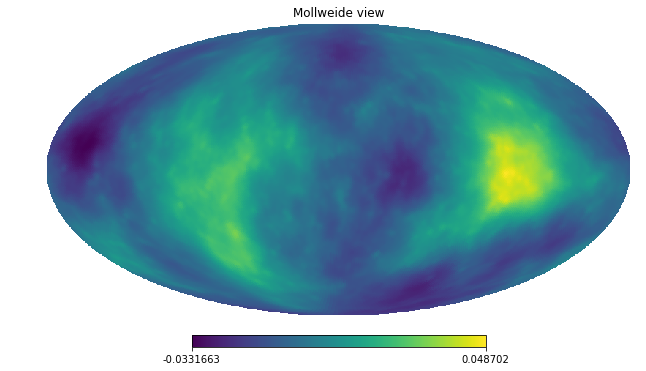

In [27]:
estimated_qft_vlm = qest_lib.get_qft_full_sky(key, cmbT_alm_filtered, e_alm_filtered, b_alm_filtered, cmbT_alm_filtered, e_alm_filtered, b_alm_filtered) #ql.qest.lens.phi_EB(cl_len.clee).eval_fullsky(e_alm_filtered, b_alm_filtered)
g_alm, c_alm = ql.shts.util.vlm2alm(estimated_qft_vlm)

cmbonly_normed_rec = hp.sphtfunc.almxfl(g_alm, np.nan_to_num(1./norm))
cmbonly_rec_map = hp.sphtfunc.alm2map(cmbonly_normed_rec, nside, lmax=lmax, pol=False)

hp.mollview(cmbonly_rec_map, cbar=True, remove_dip=True)

#### QE on foreground only

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
monopole: 1.76889e-23  dipole: lon: 15.9825, lat: 16.3073, amp: 1.48374e-17


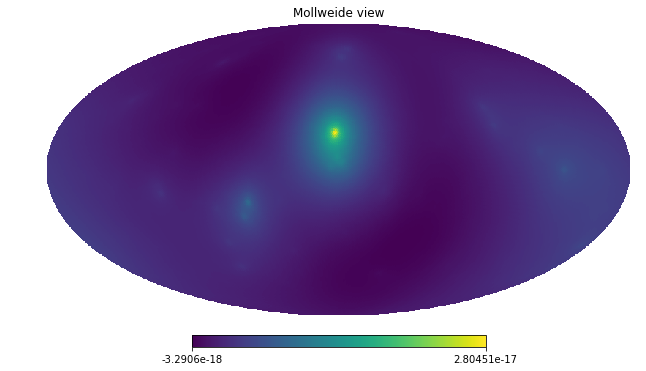

In [28]:
estimated_qft_vlm = qest_lib.get_qft_full_sky(key, fgT_alm_filtered, e_alm_filtered, b_alm_filtered, fgT_alm_filtered, e_alm_filtered, b_alm_filtered) #ql.qest.lens.phi_EB(cl_len.clee).eval_fullsky(e_alm_filtered, b_alm_filtered)
g_alm, c_alm = ql.shts.util.vlm2alm(estimated_qft_vlm)

fgonly_normed_rec = hp.sphtfunc.almxfl(g_alm, np.nan_to_num(1./norm))
fgonly_rec_map = hp.sphtfunc.alm2map(fgonly_normed_rec, nside, lmax=lmax, pol=False)

hp.mollview(fgonly_rec_map, cbar=True, remove_dip=True)

#### QE on mixed fg & lensed CMB

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
monopole: -7.42478e-17  dipole: lon: -120.028, lat: 14.3689, amp: 1.72022e-10


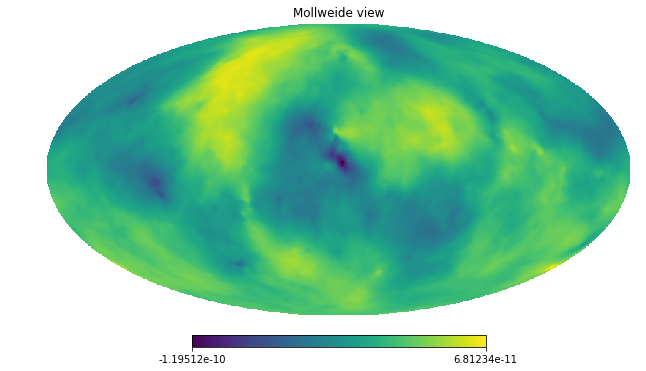

In [29]:
estimated_qft_vlm = qest_lib.get_qft_full_sky(key, cmbT_alm_filtered, e_alm_filtered, b_alm_filtered, fgT_alm_filtered, e_alm_filtered, b_alm_filtered) #ql.qest.lens.phi_EB(cl_len.clee).eval_fullsky(e_alm_filtered, b_alm_filtered)
g_alm, c_alm = ql.shts.util.vlm2alm(estimated_qft_vlm)

mixed_normed_rec = hp.sphtfunc.almxfl(g_alm, np.nan_to_num(1./norm))
mixed_rec_map = hp.sphtfunc.alm2map(mixed_normed_rec, nside, lmax=lmax, pol=False)

hp.mollview(mixed_rec_map, cbar=True, remove_dip=True)

#### Take spectra

These QEs with different inputs form the building blocks from which to construct the biases

In [30]:
def convert_phi_to_kappa(phi_map, ls, lmax, nside_out):
    phi_alm = hp.map2alm(phi_map, lmax=lmax, pol=False)
    kappa_alm = hp.sphtfunc.almxfl(phi_alm, 0.5*ls**2)
    kappa_map = hp.alm2map(kappa_alm, nside_out)
    return kappa_map

ells=np.arange(lmax+1)

cmbonly_rec_kappa_map = convert_phi_to_kappa(cmbonly_rec_map, ells, lmax, nside)
fgonly_rec_kappa_map = convert_phi_to_kappa(fgonly_rec_map, ells, lmax, nside)
mixed_rec_kappa_map = convert_phi_to_kappa(mixed_rec_map, ells, lmax, nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [31]:
# CMB lensing reconstruction auto
cmbrec_x_cmbrec = hp.sphtfunc.anafast(cmbonly_rec_kappa_map, lmax=lmax, pol=False)
# CMB lensing reconstruction cross true kappa
true_x_cmbrec = hp.sphtfunc.anafast(true_kappa, cmbonly_rec_kappa_map, lmax=lmax, pol=False)
# True kappa auto
true_x_true = hp.sphtfunc.anafast(true_kappa, true_kappa, lmax=lmax, pol=False)

# Trispectrum bias
fgonlyrec_x_fgonlyrec = hp.sphtfunc.anafast(fgonly_rec_kappa_map, lmax=lmax, pol=False)
# Primary bispectrum bias
cmbonly_x_fgonlyrec = hp.sphtfunc.anafast(cmbonly_rec_kappa_map, fgonly_rec_map, lmax=lmax, pol=False)
# Secondary bispectrum bias
mixedrec_x_mixedrec = hp.sphtfunc.anafast(mixed_rec_kappa_map, mixed_rec_kappa_map, lmax=lmax, pol=False)


For the tSZ, need to convert from compton-y to CMB temperature

In [60]:
def scale_sz(freq=150.):
    """ f_nu in the literature. this is only the non-relativistic formula. note that the formula in alexs paper is wrong. get it from sehgal et al."""
    #freq must be in GHz
    freq_hz = freq*1e9
    T_CMB = 2.7255e6
    h = 6.6260755e-27#6.62607004e-34
    K_b = 1.380658e-16#1.38064852e-23
    T_CMB_K = T_CMB/1e6
    x_nu = h*freq_hz/(K_b * T_CMB_K)
    return x_nu * np.cosh(x_nu/2.)/np.sinh(x_nu/2.) - 4

freq_GHz = 150.
T_CMB = 2.73
tsz_scaling = scale_sz(freq_GHz) * T_CMB

/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


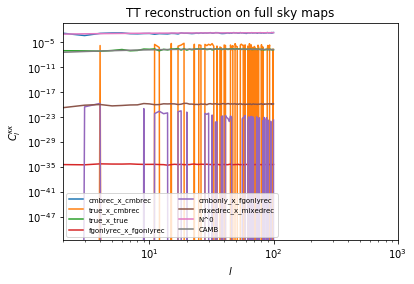

In [39]:
plt.loglog(ells, cmbrec_x_cmbrec, label='cmbrec_x_cmbrec')
plt.loglog(ells, true_x_cmbrec, label='true_x_cmbrec')
plt.loglog(ells, true_x_true, label='true_x_true')
plt.loglog(ells, tsz_scaling**4 * fgonlyrec_x_fgonlyrec, label='fgonlyrec_x_fgonlyrec')
plt.loglog(ells, tsz_scaling**2 * cmbonly_x_fgonlyrec, label='cmbonly_x_fgonlyrec')
plt.loglog(ells, tsz_scaling**2 * mixedrec_x_mixedrec, label='mixedrec_x_mixedrec')
plt.loglog((1.0/4)*1./norm*cl_unl.ls**4, label='N^0')

plt.loglog (cl_unl.ls, (1.0/4)*cl_unl.clpp*cl_unl.ls**4, label=r'CAMB')

plt.title('TT reconstruction on full sky maps')
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\kappa\kappa}$')
#plt.ylim([1e-9, 1e-5])
plt.xlim([2,1000])
plt.legend(fontsize=7, ncol=2)

# Produce first order lensing T from websky for secondary bispec bias

It's all in the script /Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/get_1storder_lensed_T.py. We load its outputs here and take the spectrum

In [47]:
g_T_alm_first_order_in_lensing = np.load('/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/g_T_alm_first_order_in_lensing.npy')

In [45]:
T_template_map = hp.sphtfunc.alm2map(g_T_alm_first_order_in_lensing, 512, lmax=3000, pol=False)
hp.mollview(T_template_map, cbar=True, remove_dip=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


ValueError: Wrong alm size.

In [49]:
cl_unl_long     = ql.spec.get_camb_scalcl(lmax=5000)
cl_len_long     = ql.spec.get_camb_lensedcl(lmax=5000)

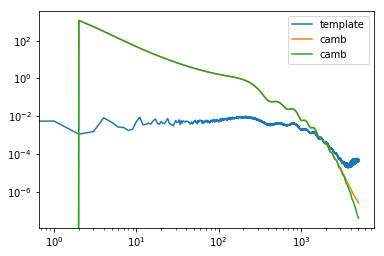

In [51]:
plt.loglog(hp.alm2cl(g_T_alm_first_order_in_lensing), label='template')
plt.loglog(cl_len_long.cltt, label='camb')
plt.loglog(cl_unl_long.cltt, label='camb')

plt.legend()

# Mixed Prim. bispec. bias

In [34]:
lmax = 3000
nside = 1024

freq_tsz = 143. # in GHz
freq_CIB = 143. # in GHz
# Masking threshold for CIB point sources
masking_threshold_mJy = 5 # in mJy

key = 'ptt'  # 'peb' # 'ptt'
# Experiment setup
nlev_t = 18.0  # 17.0 #temperature noise level, in uK.arcmin.
nlev_p = np.sqrt(2) * nlev_t  # polarization noise level, in uK.arcmin.
beam_size = 1.  # 1. #arcmin
npad = 2


### Primary bispec bias for the sum of all foregrounds

In [19]:
output_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside{}_nlevt{}_beamarcmin{}/'.format(lmax, nside, nlev_t, beam_size)
websky_dir = '/Volumes/TOSHIBA_EXT/data/sims/websky/'

qe_on_all_fgs = np.load(output_dir+'allonly_rec_map.npy')
true_kappa = hp.read_map(websky_dir + 'kap.fits')

# CMB lensing reconstruction cross true kappa
true_x_fgrec = hp.sphtfunc.anafast(true_kappa, qe_on_all_fgs, lmax=lmax, pol=False)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


<Figure size 360x360 with 0 Axes>

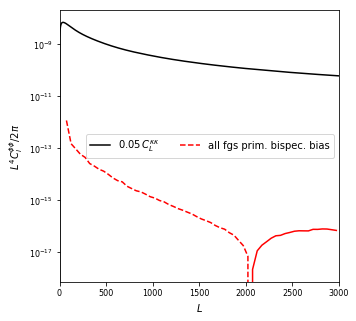

In [25]:
plt.figure(figsize=(5,5))

run_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside1024_nlevt18.0_beamarcmin1.0/'.format(lmax)

which_bias = 'all' # 'tSZ' or 'CIB' or 'all'
bin_width = 50

ells = np.arange(3000 + 1)
#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=3000)
cl_len     = ql.spec.get_camb_lensedcl(lmax=3000)


kappa_to_phi_conversion = np.nan_to_num(1 / (0.5 * ells * (ells + 1)))
scaling = ells ** 4 / (2 * np.pi) * kappa_to_phi_conversion ** 2

# Get the binned ells
ells = uniformly_bin_spectrum(true_x_allfgsrec, bin_width, return_ells=True)[1]
# PLOT
plt.figure(figsize=(5, 5))

plt.semilogy(cl_unl.ls, 0.05 * cl_unl.ls ** 4 * cl_unl.clpp / (2 * np.pi), 'k', label=r'$0.05\,C_L^{\kappa \kappa}$')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * cmbrec_x_cmbrec, bin_width), label='0.05*cmbrec_x_cmbrec', color='brown')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_cmbrec, bin_width), label=r'$0.05\, \kappa \times \hat{\kappa}$', color='gray')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_true, bin_width), label='0.05*true_x_true', color='green')

#plt.semilogy(ells, ells, color='w', label=' ')
#plt.semilogy(ells, uniformly_bin_spectrum(scaling * (fgonlyrec_x_fgonlyrec - nlpp_TT_fullsky), bin_width), label='{} trispec. bias'.format(which_bias), color='b')
plt.semilogy(ells, uniformly_bin_spectrum(- 2 * scaling * true_x_allfgsrec, bin_width), label='{} prim. bispec. bias'.format('all fgs'), color='r', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(2 * scaling * true_x_allfgsrec, bin_width), color='r')

#plt.semilogy(ells, uniformly_bin_spectrum(-4 * scaling * mixedrec_x_mixedrec, bin_width), color='orange', ls='--')
#plt.semilogy(ells, uniformly_bin_spectrum(4 * scaling * mixedrec_x_mixedrec, bin_width), label='{} second. bispec. bias'.format(which_bias), color='orange')

plt.xlabel(r'$L$')
plt.ylabel(r'$L^4 C_l^{\phi\phi}/ 2 \pi$')
plt.xlim([2, 3000])
#plt.ylim([1e-11, 1e-7])
plt.legend(ncol=2, columnspacing=2)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

#thesis_dir = '/Users/antonbaleatolizancos/Desktop/THESIS/phd_thesis/Chapter4/plots_lensing_rec_biases/'
#plt.savefig(thesis_dir+'{}_biases_on_websky_lmax{}.pdf'.format(which_bias, lmax), bbox_inches='tight')

### kappa-I-y Primary bispectrum bias 

In [40]:
def scale_sz(freq=150.):
    """
    f_nu in the literature. This is only the non-relativistic formula.
     Note that the formula in alexs paper is wrong. get it from sehgal et al.
    """
    #freq must be in GHz
    freq_hz = freq*1e9
    T_CMB = 2.7255e6
    h = 6.6260755e-27#6.62607004e-34
    K_b = 1.380658e-16#1.38064852e-23
    T_CMB_K = T_CMB/1e6
    x_nu = h*freq_hz/(K_b * T_CMB_K)
    return x_nu * np.cosh(x_nu/2.)/np.sinh(x_nu/2.) - 4

def load_tsz(nside, lmax, freq_GHz):
    """ Load Websky tSZ sim. Return it in uK units"""
    global websky_dir
    T_CMB = 2.73
    tsz_scaling = scale_sz(freq_GHz) * T_CMB * 1e6
    tsz_map = tsz_scaling * hp.remove_monopole(
        hp.ud_grade(hp.read_map(websky_dir + 'tsz.fits'), nside_out=nside))
    tsz_alm = hp.map2alm(tsz_map, lmax=lmax)
    return tsz_map, tsz_alm

def load_cib(nside, lmax, freq_CIB, masking_threshold_mJy):
    """ Load Websky CIB sim. Return it in uK units"""
    global websky_dir
    if freq_CIB==143.:
        mJy_per_sr_to_uK_at143GHz = 1e-3 / (379.93197)  # For infinitely-narrow bands
    elif freq_CIB==145.:
        mJy_per_sr_to_uK_at145GHz = 1e-3 / (385.39618) # For infinitely-narrow bands
    else:
        print 'Please hard-code unit conversion for CIB at this frequency'

    cib_map_MJy = hp.pixelfunc.remove_monopole(
        hp.ud_grade(hp.read_map(websky_dir + 'cib_nu0143.fits'), nside_out=nside))

    # Mask point sources above masking_threshold_mJy
    cib_map_mJy = 1e9 * cib_map_MJy
    # Flag the entries to be masked
    cib_map_mJy[cib_map_mJy > masking_threshold_mJy] = 0  # hp.UNSEEN
    # Mask using healpy functionality
    masked_cib_map_mJy = cib_map_mJy  # hp.pixelfunc.ma(cib_map_mJy)
    # Convert from mJy/sr to uK
    cib_map = mJy_per_sr_to_uK_at143GHz * masked_cib_map_mJy
    cib_alm = hp.map2alm(cib_map, lmax=lmax)
    return cib_map, cib_alm

def get_qe_rec_map(T_input1, T_input2):
    ''' Wrapper function to get the map QE reconstruction'''
    estimated_qft_vlm = qest_lib.get_qft_full_sky(key, T_input1, np.zeros(T_input1.shape), np.zeros(T_input1.shape),
                                                  T_input2, np.zeros(T_input1.shape),
                                                  np.zeros(T_input1.shape))
    g_alm, c_alm = ql.shts.util.vlm2alm(estimated_qft_vlm)

    normed_rec = hp.sphtfunc.almxfl(g_alm, np.nan_to_num(1. / norm))
    return hp.sphtfunc.alm2map(normed_rec, nside, lmax=lmax, pol=False)

tsz_map, tsz_alm = load_tsz(nside, lmax, freq_tsz)
cib_map, cib_alm = load_cib(nside, lmax, freq_CIB, masking_threshold_mJy)

bl = ql.spec.bl(beam_size, lmax)  # beam transfer function.

beam = ql.spec.clmat_teb(ql.util.dictobj({'lmax': lmax, 'cltt': bl, 'clee': bl, 'clbb': bl}))
cl_theory = ql.spec.clmat_teb(ql.util.dictobj({'lmax': lmax, 'cltt': cl_len.cltt, 'clee': cl_len.clee, 'clbb': cl_len.clbb}))

ivf_lib = ql.sims.ivf.library_diag_full_sky(cl_theory, beam, nlev_t=nlev_t, nlev_p=nlev_p)
qest_lib = ql.sims.qest.library(cl_unl, cl_len, ivf_lib, npad=npad)
norm = qest_lib.get_qr_full_sky('ptt')

tsz_alm_alm_filtered = ivf_lib.ivf_alm_array(tsz_alm, 'cltt')
cib_alm_alm_filtered = ivf_lib.ivf_alm_array(cib_alm, 'cltt')

Iy_rec_map = get_qe_rec_map(tsz_alm_alm_filtered, cib_alm_alm_filtered)
np.save(output_dir + 'Iy_rec_map', Iy_rec_map)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in divide


In [44]:
output_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside{}_nlevt{}_beamarcmin{}/'.format(lmax, nside, nlev_t, beam_size)
websky_dir = '/Volumes/TOSHIBA_EXT/data/sims/websky/'

Iy_rec_map = np.load(output_dir+'Iy_rec_map.npy')
true_kappa = hp.read_map(websky_dir + 'kap.fits')

# CMB lensing reconstruction cross true kappa
true_x_mixedfgrec = hp.sphtfunc.anafast(true_kappa, Iy_rec_map, lmax=lmax, pol=False)

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in divide
  
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/antonbaleatolizancos/opt/anaconda3/envs/lensing_py2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


<Figure size 360x360 with 0 Axes>

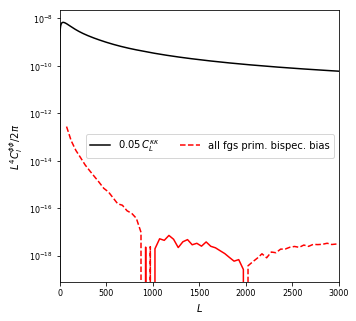

In [47]:
plt.figure(figsize=(5,5))

run_dir = '/Users/antonbaleatolizancos/Projects/lensing_rec_biases/scripts/biases_from_websky_lmax{}_nside1024_nlevt18.0_beamarcmin1.0/'.format(lmax)

which_bias = 'qll' # 'tSZ' or 'CIB' or 'all'
bin_width = 50

ells = np.arange(3000 + 1)
#Your theory spectra
cl_unl     = ql.spec.get_camb_scalcl(lmax=3000)
cl_len     = ql.spec.get_camb_lensedcl(lmax=3000)


kappa_to_phi_conversion = np.nan_to_num(1 / (0.5 * ells * (ells + 1)))
scaling = ells ** 4 / (2 * np.pi) * kappa_to_phi_conversion ** 2

# Get the binned ells
ells = uniformly_bin_spectrum(true_x_allfgsrec, bin_width, return_ells=True)[1]
# PLOT
plt.figure(figsize=(5, 5))

plt.semilogy(cl_unl.ls, 0.05 * cl_unl.ls ** 4 * cl_unl.clpp / (2 * np.pi), 'k', label=r'$0.05\,C_L^{\kappa \kappa}$')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * cmbrec_x_cmbrec, bin_width), label='0.05*cmbrec_x_cmbrec', color='brown')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_cmbrec, bin_width), label=r'$0.05\, \kappa \times \hat{\kappa}$', color='gray')
#plt.semilogy(ells, uniformly_bin_spectrum(0.05 * scaling * true_x_true, bin_width), label='0.05*true_x_true', color='green')

#plt.semilogy(ells, ells, color='w', label=' ')
#plt.semilogy(ells, uniformly_bin_spectrum(scaling * (fgonlyrec_x_fgonlyrec - nlpp_TT_fullsky), bin_width), label='{} trispec. bias'.format(which_bias), color='b')
plt.semilogy(ells, uniformly_bin_spectrum(- 2 * scaling * true_x_mixedfgrec, bin_width), label='{} prim. bispec. bias'.format('all fgs'), color='r', ls='--')
plt.semilogy(ells, uniformly_bin_spectrum(2 * scaling * true_x_mixedfgrec, bin_width), color='r')

#plt.semilogy(ells, uniformly_bin_spectrum(-4 * scaling * mixedrec_x_mixedrec, bin_width), color='orange', ls='--')
#plt.semilogy(ells, uniformly_bin_spectrum(4 * scaling * mixedrec_x_mixedrec, bin_width), label='{} second. bispec. bias'.format(which_bias), color='orange')

plt.xlabel(r'$L$')
plt.ylabel(r'$L^4 C_l^{\phi\phi}/ 2 \pi$')
plt.xlim([2, 3000])
#plt.ylim([1e-11, 1e-7])
plt.legend(ncol=2, columnspacing=2)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)

#thesis_dir = '/Users/antonbaleatolizancos/Desktop/THESIS/phd_thesis/Chapter4/plots_lensing_rec_biases/'
#plt.savefig(thesis_dir+'{}_biases_on_websky_lmax{}.pdf'.format(which_bias, lmax), bbox_inches='tight')